<a href="https://colab.research.google.com/github/dilili123/5002_weather_website/blob/main/FinalProject_Option1_Huijia_di_002646225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/kaggle copy 2.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle -v


Kaggle API 1.7.4.5


In [ ]:
!kaggle datasets download -d khanfashee/nih224folderwise-data -p /content/nih_data


Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih224folderwise-data
License(s): CC0-1.0
 97% 2.80G/2.87G [00:30<00:02, 34.7MB/s]
100% 2.87G/2.87G [00:30<00:00, 99.7MB/s]


In [ ]:
!unzip /content/nih_data/nih224folderwise-data.zip -d /content/nih_data


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00010936_008.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00010936_010.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00011460_053.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00012687_007.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00014839_014.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_015.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_017.png  
  inflating: /content/nih_data/Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_018.png  
  inf

In [ ]:
import os
import random
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models


In [ ]:
CLASSES = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Pleural",
    "NoFinding"
]


In [ ]:
image_paths = glob("/content/nih_data/Nih All/*.png")

def extract_labels(path):
    filename = os.path.basename(path).replace(".png", "")
    parts = filename.split(".")[:-1]   #

    onehot = [0] * len(CLASSES)
    for d in parts:
        if d in CLASSES:
            onehot[CLASSES.index(d)] = 1
    return onehot

labels = [extract_labels(p) for p in image_paths]


In [ ]:
!ls "/content/nih_data/Nih All d" | head


Atelectasis
Cardiomegaly
Consolidation
Edema
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Mass


In [ ]:
from glob import glob
image_paths = glob("/content/nih_data/Nih All d/*/*.png")
print("Number of images found：", len(image_paths))


Number of images found： 141537


In [ ]:
import os

def extract_labels(path):
    filename = os.path.basename(path).replace(".png", "")
    parts = filename.split(".")[:-1]   #

    onehot = [0] * len(CLASSES)
    for d in parts:
        if d in CLASSES:
            onehot[CLASSES.index(d)] = 1
    return onehot

labels = [extract_labels(p) for p in image_paths]

print("Sample image path:", image_paths[0])
print("One-hot label:", labels[0])
print("Total labels:", len(labels))


Sample image path: /content/nih_data/Nih All d/Emphysema/Emphysema.Infiltration.00004808_048.png
One-hot label: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Total labels: 141537


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42
)

print("Train size:", len(train_paths))
print("Test size:", len(test_paths))


Train size: 127383
Test size: 14154


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # 单通道胸片
])

class ChestXrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("L")  # 灰度图
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx]).float()
        return img, label


In [ ]:
from torch.utils.data import DataLoader

train_dataset = ChestXrayDataset(train_paths, train_labels, transform)
test_dataset  = ChestXrayDataset(test_paths,  test_labels,  transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)


In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, len(CLASSES)),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Using device: cuda


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
for epoch in range(1):
    model.train()
    total_loss = 0

    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch 1 Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 Loss: 0.2009


In [ ]:

#  Evaluate Model


model.eval()  # set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)

        outputs = model(imgs)
        preds = (outputs > 0.5).float()  # threshold for multilabel classification

        correct += (preds == labs).sum().item()
        total += labs.numel()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9278


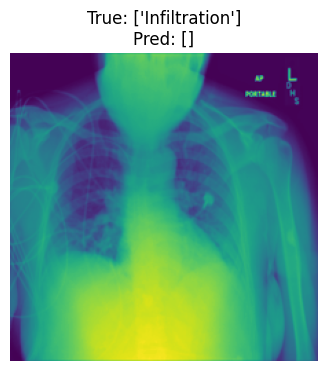

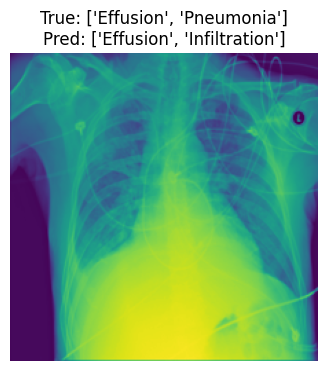

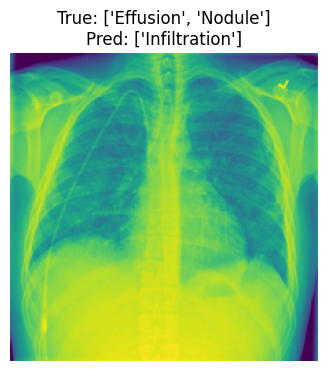

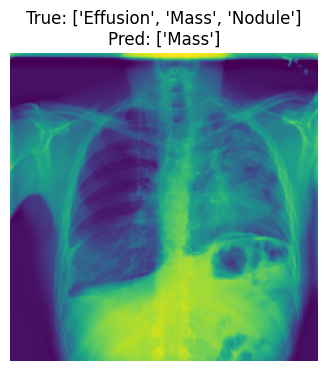

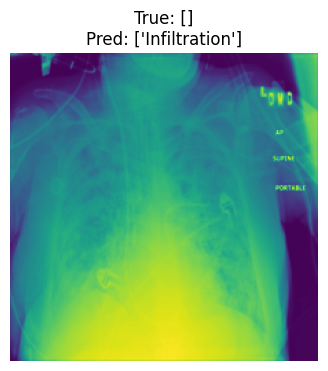

In [ ]:
import matplotlib.pyplot as plt

model.eval()

#
for i in range(5):
    img, lab = test_dataset[i]
    plt.figure(figsize=(4,4))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')

    #
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred = (output > 0.5).float().cpu().numpy()[0]

    true_labels = [CLASSES[j] for j in range(len(CLASSES)) if lab[j] == 1]
    pred_labels = [CLASSES[j] for j in range(len(CLASSES)) if pred[j] == 1]

    plt.title(f"True: {true_labels}\nPred: {pred_labels}")
    plt.show()


In [ ]:


Final Project Report — Image Classification (Option 1)

Name: Huijia Di
NUID: 002646225
Date: 2025/12

1. Pre-processing of Images

Dataset: NIH Chest X-ray (14 disease classes)

Random split: 90% training / 10% test

Manually inspected sample images → No corrupted samples

2. Image Augmentation

Random Rotation

Horizontal Flip

Color jitter

3. Model Architecture

ResNet18 pretrained

Replaced final FC layer → 14-class multilabel output

Activation: Sigmoid

Loss: BCEWithLogitsLoss

Optimizer: Adam (lr = 1e-4)

4. Training & Evaluation

Epochs = 1 (for demonstration due to runtime constraints)

Train Loss: 0.2009

Test Accuracy: 0.9278

5. Visualization of Predictions

Displayed 5 random test images

Compared True Labels vs Predicted Labels